# 第一次尝试Clip
## 只针对gender和age（artifact和session不好编写prompt，而且也不是很特色化的信息）
## 同时训练所有受试者
### 11.2第三次尝试

## 第1步：导入、设置与辅助函数

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import pickle
import os
import time
import pandas as pd
import random
import math

def set_seed(seed):
    """设置所有随机种子以确保结果可复现"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    g = torch.Generator()
    g.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    return g

# --- 辅助模块: EEGNet的原始组件 (保持不变) ---
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                     groups=in_channels, bias=bias, padding='same')
        self.pointwise = nn.Conv2d(in_channels, out_channels, 
                                     kernel_size=1, bias=bias)
    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

## 第2步：修改后的 BCI2aDataset

In [2]:
# Cell 2: 【已修改】的 BCI2aDataset (支持多受试者)
class BCI2aDataset(torch.utils.data.Dataset):
    """
    修改后的数据集类 (Dataset Class)
    - __init__ 接收一个 data_paths 列表 (而不是单个路径)
    - 循环加载并堆叠所有受试者的数据
    - __getitem__ 返回 (eeg_data, action_label, subject_id)
    """
    def __init__(
        self,
        data_paths: list,  # (修改) 接收一个路径列表
    ):
        
        all_data = []         # 用于存储所有受试者的 'x' 数据
        all_labels = []       # 用于存储所有受试者的 'y' 标签
        all_subject_ids = []  # 用于存储每个样本对应的 subject_id

        print("--- 正在加载多受试者数据... ---")
        
        # 遍历您传入的 9 个文件路径
        for data_path in data_paths:
            # --- 提取受试者ID ---
            # 从 "A01T.pkl" 中提取 "A01T"
            subjectName = os.path.splitext(os.path.basename(data_path))[0]
            # 从 "A01T" 中提取 "01"，转为整数 1，再减 1 得到索引 0
            subject_id = int(subjectName[1:3]) - 1

            # --- 加载数据 ---
            with open(data_path, "rb") as f:
                sub_data = pickle.load(f)
            
            # 获取当前文件中的样本数 (例如 288)
            num_samples = len(sub_data['y'])
            
            # --- 收集数据 ---
            all_data.append(sub_data['x'])            # 添加 (288, 22, 512) 的数据
            all_labels.append(sub_data['y'])          # 添加 (288,) 的标签
            # 创建一个长度为 num_samples 的数组，全部填充为该受试者的 ID
            all_subject_ids.append(np.full(num_samples, subject_id, dtype=int))
            
            print(f"  > 已加载 {subjectName}: {num_samples} 个样本, Subject ID: {subject_id}")

        # --- 将所有数据堆叠成大数组 ---
        # np.concatenate 会将 9 个 (288, 22, 512) 堆叠成 (2592, 22, 512)
        self.data = torch.from_numpy(np.concatenate(all_data, axis=0)).type(torch.FloatTensor)
        # 标签 (y) 是 [1, 2, 3, 4], 我们需要 [0, 1, 2, 3]
        self.labels = torch.tensor(np.concatenate(all_labels, axis=0), dtype=torch.long) - 1
        # 将 9 个 (288,) 的ID数组堆叠成 (2592,)
        self.subject_ids = torch.tensor(np.concatenate(all_subject_ids, axis=0), dtype=torch.long)
        
        print(f"--- 总计加载 {len(self.labels)} 个样本 ---")
            
    def __len__(self):
        # 返回数据集中样本的总数 (例如 2592)
        return len(self.labels)

    def __getitem__(self, i):
        # 根据索引 i 获取单个数据样本
        # (修改) self.subject_ids[i] 现在从数组中动态获取ID
        return self.data[i], self.labels[i], self.subject_ids[i]

## 第3步：修改后的 EEGNet（作为编码器）

In [3]:
class EEGNet_Encoder(nn.Module):
    """
    修改后的 EEGNet，作为 EEG 编码器。
    - 移除了 inputMeta 和 num_class
    - 移除了 fc1 (分类头)
    - forward 方法返回 flatten 后的 (B, 512) 特征向量
    """
    def __init__(self, no_spatial_filters, no_channels, no_temporal_filters, temporal_length_1, temporal_length_2, window_length, drop_out_ratio=0.50, pooling2=4, pooling3=8):
        super(EEGNet_Encoder, self).__init__()
        self.drop_out_ratio = drop_out_ratio
        
        # --- 第1层: 时间卷积 ---
        self.conv1 = nn.Conv2d(1, no_temporal_filters, (1, temporal_length_1), padding='same', bias=False)
        self.batchnorm1 = nn.BatchNorm2d(no_temporal_filters, False)
        
        # --- 第2层: 深度空间卷积 ---
        self.conv2 = nn.Conv2d(no_temporal_filters, no_temporal_filters * no_spatial_filters, (no_channels, 1),
                                 groups=no_temporal_filters, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(no_temporal_filters * no_spatial_filters, False)
        self.pooling2 = nn.AvgPool2d(1, pooling2)
        self.dropout = nn.Dropout(self.drop_out_ratio) # Dropout层
        
        # --- 第3层: 可分离卷积 ---
        self.separableConv2 = SeparableConv2d(no_temporal_filters * no_spatial_filters,
                                              no_temporal_filters * no_spatial_filters, (1, temporal_length_2))
        self.batchnorm3 = nn.BatchNorm2d(no_temporal_filters * no_spatial_filters, False)
        self.pooling3 = nn.AvgPool2d((1, pooling3))
        
        # --- 辅助函数: 自动计算全连接层输入维度 ---
        # 我们仍然需要这个函数来确保知道输出维度是 512
        eeg_random = torch.randn(4, no_channels, window_length)
        self.fc_length = self.calc_fc_features(eeg_random)
        print(f"--- EEGNet 编码器初始化完成，输出特征维度: {self.fc_length} ---")

    def calc_fc_features(self, x,):
        # (这个辅助函数保持不变)
        self.eval()
        with torch.no_grad():
            x = torch.unsqueeze(x, 1)
            x = self.conv1(x)
            x = self.batchnorm1(x)
            x = self.conv2(x)
            B, FB, Ch, TL = x.shape
            x = torch.reshape(x, (B, FB * Ch, 1, TL))
            x = nn.functional.elu(self.batchnorm2(x))
            x = self.pooling2(x)
            x = self.dropout(x)
            x = self.separableConv2.forward(x)
            x = nn.functional.elu(self.batchnorm3(x))
            x = self.pooling3(x)
            x = self.dropout(x)
            x = torch.flatten(x, start_dim=1)
            return x.shape[-1]
            
    def forward(self, x):
        # --- 核心: 前向传播 ---
        x = torch.unsqueeze(x, 1)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        
        x = self.conv2(x)
        B, FB, Ch, TL = x.shape
        x = torch.reshape(x, (B, FB * Ch, 1, TL))
        x = nn.functional.elu(self.batchnorm2(x))
        x = self.pooling2(x)
        x = self.dropout(x)

        x = self.separableConv2.forward(x)
        x = nn.functional.elu(self.batchnorm3(x))
        x = self.pooling3(x)
        x = self.dropout(x)
        
        # --- 返回特征 ---
        x = torch.flatten(x, start_dim=1) # (B, 512)
        return x

## 第4步：新的投影头和CLIP主模型

In [4]:
class ProjectionHead(nn.Module):
    """
    按您要求设计的投影头 (决定 3-B):
    两层 MLP + GELU + 残差连接 + LayerNorm
    """
    def __init__(self, in_dim: int, out_dim: int = 256, hidden_dim: int = 1024):
        super().__init__()
        # 瓶颈层 (Bottleneck) 结构
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(0.5) # <--- 新增 Dropout
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        
        # 残差连接 (如果输入输出维度不同，则使用一个线性层来匹配)
        if in_dim == out_dim:
            self.residual_proj = nn.Identity()
        else:
            self.residual_proj = nn.Linear(in_dim, out_dim, bias=False)
            
        self.norm = nn.LayerNorm(out_dim) # 最终的 LayerNorm

    def forward(self, x):
        # F(x)
        # x_proj = self.fc2(self.gelu(self.fc1(x)))
        x_proj = self.fc2(self.dropout(self.gelu(self.fc1(x)))) # <--- 在此应用 Dropout
        # residual(x)
        residual = self.residual_proj(x)
        
        # F(x) + residual(x), 然后 LayerNorm
        return self.norm(x_proj + residual)



class EEGClipModel(nn.Module):
    """
    将 EEG 编码器和文本原型/投影头组合在一起的 CLIP 主模型
    """
    def __init__(self, eeg_encoder, text_prototypes_tensor, eeg_dim=512, text_dim=1024, embed_dim=256):
        super().__init__()
        self.eeg_encoder = eeg_encoder
        
        # 投影头
        self.eeg_proj_head = ProjectionHead(in_dim=eeg_dim, out_dim=embed_dim)
        self.text_proj_head = ProjectionHead(in_dim=text_dim, out_dim=embed_dim)
        
        # 存储文本原型 (9个受试者 x 4个类别 x 1024维)
        # 注册为 'buffer'，它不会被训练，但会随模型一起保存和移动到 .to(device)
        self.register_buffer("text_prototypes", text_prototypes_tensor)
        # --- 可学习的温度参数（以 logit_scale 形式存储） ---
        # 与 temperature=0.07 等价的初始化：logit_scale = log(1/0.07)
        self.logit_scale = nn.Parameter(torch.log(torch.tensor(1.0 / 0.1)))

    def get_temperature(self):
        # τ = 1 / exp(logit_scale)
        return torch.exp(-self.logit_scale)

    def get_logit_scale(self):
        # s = exp(logit_scale)
        return torch.exp(self.logit_scale)

    def encode_eeg(self, eeg_data):
        """编码EEG数据: EEGNet -> ProjHead"""
        eeg_features = self.eeg_encoder(eeg_data) # (B, 512)
        eeg_embeds = self.eeg_proj_head(eeg_features) # (B, 256)
        return eeg_embeds

    def encode_text(self):
        """编码文本原型: Prototypes -> ProjHead"""
        # (9, 4, 1024) -> (36, 1024)
        prototypes_flat = self.text_prototypes.view(-1, self.text_prototypes.shape[-1])
        
        # (36, 1024) -> (36, 256)
        text_embeds = self.text_proj_head(prototypes_flat)
        
        # (36, 256) -> (9, 4, 256)
        text_embeds_grouped = text_embeds.view(
            self.text_prototypes.shape[0],
            self.text_prototypes.shape[1],
            -1
        )
        return text_embeds_grouped

    def forward(self, eeg_data):
        """
        前向传播: 同时编码 EEG 和 文本
        """
        eeg_embeds = self.encode_eeg(eeg_data)    # (B, 256)
        text_embeds = self.encode_text()         # (9, 4, 256)
        return eeg_embeds, text_embeds

## 第5步：加载原型和CLIP损失函数

In [5]:
def load_prototypes(prototype_dir, subjects=9, classes=None):
    """
    加载所有 36 个 .pt 原型文件
    """
    if classes is None:
        classes = ["left_hand", "right_hand", "feet", "tongue"]
    
    all_prototypes = []
    print(f"--- 正在从 {prototype_dir} 加载原型... ---")
    
    for s_id in range(1, subjects + 1): # 循环 S01 到 S09
        subject_prototypes = []
        for cls in classes: # 循环 4 个类别
            file_name = f"S{s_id:02d}_{cls}.pt"
            file_path = os.path.join(prototype_dir, file_name)
            
            try:
                tensor = torch.load(file_path, map_location='cpu')
                subject_prototypes.append(tensor)
            except FileNotFoundError:
                print(f"错误: 找不到文件 {file_path}")
                return None
        
        # (4, 1024)
        all_prototypes.append(torch.stack(subject_prototypes))
        
    # (9, 4, 1024)
    final_tensor = torch.stack(all_prototypes)
    print(f"原型加载成功! 最终张量维度: {final_tensor.shape}")
    return final_tensor

def clip_loss(eeg_embeds, text_embeds_grouped, eeg_labels, eeg_subject_ids, logit_scale):
    """
    4类对比（跨被试聚合）：
    - 用所有 36 个原型，但对同一动作的 9 个受试者原型做 log-sum-exp 聚合，
      得到每个动作的“组对数似然”作为该类的 logit。
    """
    # 1) 归一化
    eeg_embeds = F.normalize(eeg_embeds, p=2, dim=-1)             # [B,256]
    text = F.normalize(text_embeds_grouped, p=2, dim=-1)          # [9,4,256]

    B, D = eeg_embeds.shape

    # 2) 计算与所有 36 个原型的相似度：先铺平成 [36,256]
    text_flat = text.view(-1, D)                                  # [36,256]
    sim = eeg_embeds @ text_flat.T                                # [B,36]

    # 3) reshape 成 [B, 9(受试者), 4(动作)]
    sim = sim.view(B, 9, 4)                                       # [B,9,4]

    # 4) 乘可学习缩放（=1/τ）
    scale = torch.exp(torch.clamp(logit_scale, min=-5.0, max=5.0))
    sim = sim * scale                                             # [B,9,4]

    # 5) 对受试者维度做 log-sum-exp 聚合 → 得到 4 类 logits
    #    相当于“对受试者边缘化”，保留动作判别，利用所有负样本
    class_logits = torch.logsumexp(sim, dim=1)                    # [B,4]

    # 6) 4类交叉熵（可适度 label smoothing）
    loss = F.cross_entropy(class_logits, eeg_labels, label_smoothing=0.05)
    return loss



## 第6步：训练与评估函数

In [6]:
def run_epoch_clip(model, loader, optimizer, criterion, device, all_prototypes_tensor):
    """
    训练一个 epoch（36 类对比）
    """
    model.train()
    total_loss = 0.0

    for eeg_data, action_labels, subject_ids in loader:
        # 1) 数据上设备
        eeg_data      = eeg_data.to(device)           # [B,22,512]
        action_labels = action_labels.to(device)      # [B]
        subject_ids   = subject_ids.to(device)        # [B]

        optimizer.zero_grad()

        # 2) 前向：取 EEG 嵌入 [B,256] 与 文本分组嵌入 [9,4,256]
        eeg_embeds, text_embeds_grouped = model(eeg_data)

        # 3) 36 类对比损失
        loss = criterion(eeg_embeds, text_embeds_grouped,
                         action_labels, subject_ids, model.logit_scale)

        # 4) 反传与更新
        loss.backward()
        optimizer.step()

        # 5) 累加 batch 损失（按样本数加权）
        total_loss += loss.item() * eeg_data.size(0)

    return total_loss / len(loader.dataset)


# Cell 6: evaluate_clip
def evaluate_clip(model, loader, criterion, device, all_prototypes_tensor):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    
    with torch.no_grad():
        # 1) 预先计算所有36个文本嵌入 [9,4,256]
        text_embeds_grouped = model.encode_text()
        
        for eeg_data, action_labels, subject_ids in loader:
            eeg_data = eeg_data.to(device)
            action_labels = action_labels.to(device)
            subject_ids = subject_ids.to(device)
            
            # 2) EEG 编码
            eeg_embeds = model.encode_eeg(eeg_data) # [B, 256]

            # 3) 计算损失 (与训练时完全一致)
            loss = criterion(eeg_embeds, text_embeds_grouped, action_labels, subject_ids, model.logit_scale)
            total_loss += loss.item() * eeg_data.size(0)

            # --- 4. 计算准确率 (【关键修改】) ---
            
            # 归一化
            eeg_embeds_norm = F.normalize(eeg_embeds, p=2, dim=-1)
            text_embeds_norm = F.normalize(text_embeds_grouped, p=2, dim=-1)
            
            # (与 clip_loss 内部逻辑相同)
            B, D = eeg_embeds_norm.shape
            text_flat = text_embeds_norm.view(-1, D)             # [36, 256]
            sim = eeg_embeds_norm @ text_flat.T                  # [B, 36]
            sim = sim.view(B, 9, 4)                              # [B, 9, 4]
            scale = torch.exp(model.logit_scale)                 # 获取缩放
            
            # 聚合得到 4 分类的 logits [B, 4]
            class_logits = torch.logsumexp(sim * scale, dim=1)
            
            # 在 4 个动作类别中找到预测值
            pred_action = class_logits.argmax(dim=-1)            # [B]
            
            total_correct += (pred_action == action_labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / len(loader.dataset)
    return avg_loss, accuracy


## 第7步：主执行程序（训练循环）

In [7]:
# Cell 7: 【已修改】的主执行程序 (加载全部9个受试者)

# --- 1. 设置参数 ---
SEED_VALUE = 42
PROTOTYPE_DIR = "/data/leuven/379/vsc37996/test/textCoder/subject_prototypes" # [!!!] 您的 .pt 文件夹路径
# --- (关键修改) ---
BASE_PATH = "/lustre1/project/stg_00160/EEG_LLM/" # [!!!] 您的 .pkl 文件基础路径
# --- (修改结束) ---

EEG_DIM = 512    # EEGNet的输出
TEXT_DIM = 1024  # Qwen 向量的维度
EMBED_DIM = 256  # 统一的嵌入空间维度

# --- 训练超参数 ---
batch_size = 32
epochs = 100
lr = 1e-4 # CLIP 训练通常使用较小的学习率
weight_decay = 1e-3

# --- 2. 准备工作 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_loader_generator = set_seed(SEED_VALUE)
print(f"--- 正在 {device} 上运行 ---")

# --- 3. 加载数据 ---
# 加载 36 个文本原型 (9, 4, 1024)
all_prototypes_tensor = load_prototypes(PROTOTYPE_DIR).to(device)

# --- (关键修改) 构建所有9个受试者的文件路径列表 ---
num_subjects_to_load = 9 # 加载全部 9 个
train_paths = [os.path.join(BASE_PATH, f"A{i:02d}T.pkl") for i in range(1, num_subjects_to_load + 1)]
test_paths = [os.path.join(BASE_PATH, f"A{i:02d}E.pkl") for i in range(1, num_subjects_to_load + 1)]
# --- (修改结束) ---

# 实例化多受试者数据集
train_dataset = BCI2aDataset(data_paths=train_paths)
test_dataset = BCI2aDataset(data_paths=test_paths)

print(f"训练数据: {len(train_dataset)} 样本")
print(f"测试数据: {len(test_dataset)} 样本")

# 实例化数据加载器
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=0, pin_memory=True, drop_last=True, 
    generator=data_loader_generator
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True, drop_last=False
)

# --- 4. 实例化模型和优化器 ---
# 实例化 EEG 编码器
eeg_encoder = EEGNet_Encoder(
    no_spatial_filters=4, no_channels=22, no_temporal_filters=8,
    temporal_length_1=64, temporal_length_2=16, 
    window_length=int(4*128), # 512
    drop_out_ratio=0.5
)

# 实例化 CLIP 主模型
model = EEGClipModel(
    eeg_encoder=eeg_encoder,
    text_prototypes_tensor=all_prototypes_tensor,
    eeg_dim=EEG_DIM,
    text_dim=TEXT_DIM,
    embed_dim=EMBED_DIM
).to(device)

# 定义损失函数和优化器
criterion = clip_loss # 使用我们自定义的损失函数
# (优化器设置保持不变)
base_params = [p for n, p in model.named_parameters() if n != "logit_scale"]
optimizer = optim.Adam(
    [
        {"params": base_params,          "lr": lr,   "weight_decay": weight_decay},
        {"params": [model.logit_scale],  "lr": 1e-3, "weight_decay": 0.0},
    ]
)

# --- 5. 开始训练 ---
best_test_acc = 0.0
print(f"\n--- 开始 CLIP 训练 (共 {epochs} 轮) ---")

history = {
    "epoch": [],"train_loss": [],"test_loss": [],
    "test_acc": [], "tau": [], "logit_scale": []
}

# (训练循环保持不变)
for epoch in range(1, epochs + 1):
    train_loss = run_epoch_clip(model, train_loader, optimizer, criterion, device, all_prototypes_tensor)
    test_loss, test_acc = evaluate_clip(model, test_loader, criterion, device, all_prototypes_tensor)

    with torch.no_grad():
        try:
            cur_tau = model.get_temperature().item()
            cur_s   = model.get_logit_scale().item()
        except AttributeError:
            cur_tau, cur_s = float("nan"), float("nan")

    # 追加到历史
    history["epoch"].append(epoch)
    history["train_loss"].append(float(train_loss))
    history["test_loss"].append(float(test_loss))
    history["test_acc"].append(float(test_acc))
    history["tau"].append(cur_tau)
    history["logit_scale"].append(cur_s)

    if test_acc > best_test_acc:
        best_test_acc = test_acc

    if epoch % 10 == 0 or epoch == 1:
        print(f"[epoch {epoch}] temperature τ={cur_tau:.5f}, logit_scale s={cur_s:.5f}")

    print(
        f"Epoch {epoch:03d} | "
        f"train_loss: {train_loss:.4f} | "
        f"test_loss: {test_loss:.4f}   test_acc: {test_acc*100:.2f}%"
    )

print(f"\n--- 训练完成 ---")
print(f"最佳测试准确率 (CLIP): {best_test_acc*100:.2f}%")

# (保存CSV的代码保持不变)
import pandas as pd
history_df = pd.DataFrame(history)
history_df.to_csv("clip_training_history.csv", index=False)
print("已保存训练曲线到 clip_training_history.csv")

--- 正在 cuda 上运行 ---
--- 正在从 /data/leuven/379/vsc37996/test/textCoder/subject_prototypes 加载原型... ---
原型加载成功! 最终张量维度: torch.Size([9, 4, 1024])
--- 正在加载多受试者数据... ---
  > 已加载 A01T: 288 个样本, Subject ID: 0
  > 已加载 A02T: 288 个样本, Subject ID: 1
  > 已加载 A03T: 288 个样本, Subject ID: 2
  > 已加载 A04T: 288 个样本, Subject ID: 3
  > 已加载 A05T: 288 个样本, Subject ID: 4
  > 已加载 A06T: 288 个样本, Subject ID: 5
  > 已加载 A07T: 288 个样本, Subject ID: 6
  > 已加载 A08T: 288 个样本, Subject ID: 7
  > 已加载 A09T: 288 个样本, Subject ID: 8
--- 总计加载 2592 个样本 ---
--- 正在加载多受试者数据... ---
  > 已加载 A01E: 288 个样本, Subject ID: 0
  > 已加载 A02E: 288 个样本, Subject ID: 1
  > 已加载 A03E: 288 个样本, Subject ID: 2
  > 已加载 A04E: 288 个样本, Subject ID: 3
  > 已加载 A05E: 288 个样本, Subject ID: 4
  > 已加载 A06E: 288 个样本, Subject ID: 5
  > 已加载 A07E: 288 个样本, Subject ID: 6
  > 已加载 A08E: 288 个样本, Subject ID: 7
  > 已加载 A09E: 288 个样本, Subject ID: 8
--- 总计加载 2592 个样本 ---
训练数据: 2592 样本
测试数据: 2592 样本
--- EEGNet 编码器初始化完成，输出特征维度: 512 ---


/data/leuven/379/vsc37996/miniconda3/envs/test1/lib/python3.11/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv2d(



--- 开始 CLIP 训练 (共 100 轮) ---
[epoch 1] temperature τ=0.10064, logit_scale s=9.93690
Epoch 001 | train_loss: 1.3652 | test_loss: 1.3089   test_acc: 38.85%
Epoch 002 | train_loss: 1.3097 | test_loss: 1.2904   test_acc: 40.82%
Epoch 003 | train_loss: 1.2776 | test_loss: 1.2948   test_acc: 42.82%
Epoch 004 | train_loss: 1.2561 | test_loss: 1.2749   test_acc: 44.79%
Epoch 005 | train_loss: 1.2331 | test_loss: 1.2295   test_acc: 46.88%
Epoch 006 | train_loss: 1.2182 | test_loss: 1.2415   test_acc: 47.76%
Epoch 007 | train_loss: 1.2164 | test_loss: 1.2517   test_acc: 47.76%
Epoch 008 | train_loss: 1.1903 | test_loss: 1.2431   test_acc: 48.38%
Epoch 009 | train_loss: 1.1892 | test_loss: 1.2149   test_acc: 50.04%
[epoch 10] temperature τ=0.10120, logit_scale s=9.88127
Epoch 010 | train_loss: 1.1748 | test_loss: 1.2089   test_acc: 50.35%
Epoch 011 | train_loss: 1.1729 | test_loss: 1.2124   test_acc: 49.54%
Epoch 012 | train_loss: 1.1468 | test_loss: 1.2265   test_acc: 50.66%
Epoch 013 | train_l

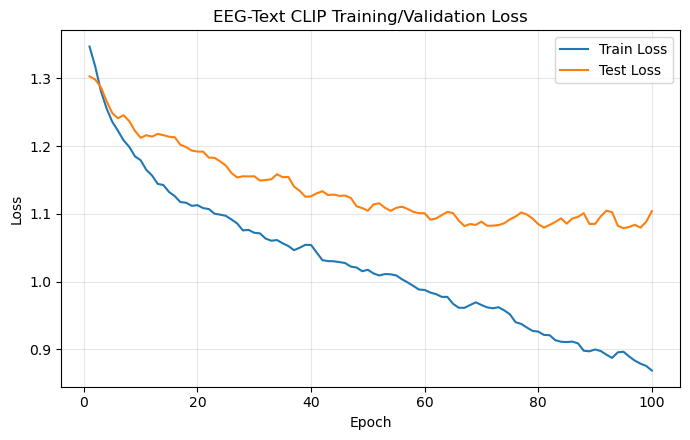

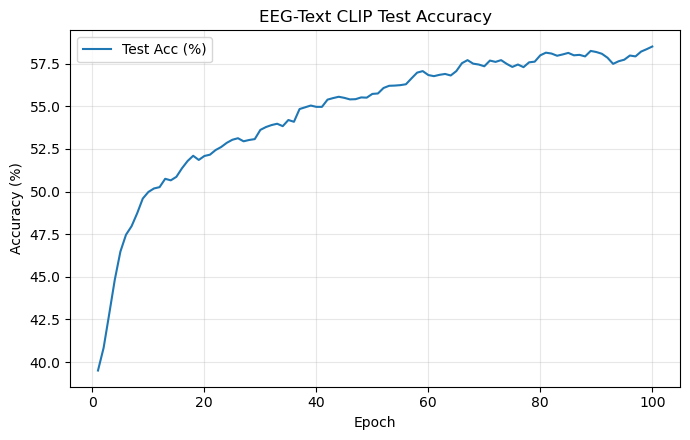

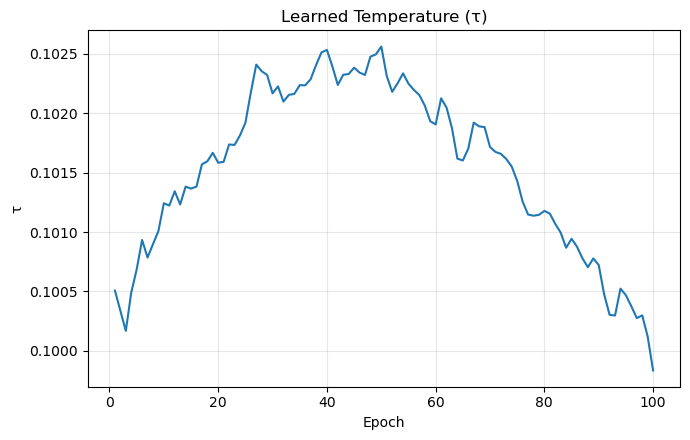

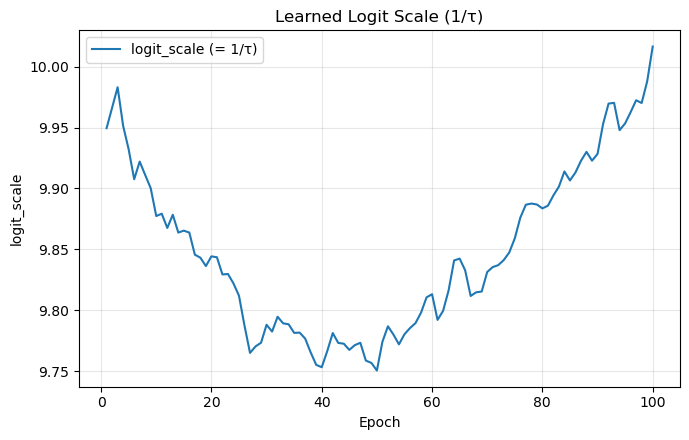

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取训练历史
df = pd.read_csv("clip_training_history.csv")

def smooth(y, k=5):
    if k <= 1:
        return y
    # 简单移动平均平滑
    kernel = np.ones(k) / k
    # 边界用 nearest 方式扩展
    pad = k // 2
    y_pad = np.pad(y, (pad, pad), mode='edge')
    y_smooth = np.convolve(y_pad, kernel, mode='valid')
    return y_smooth

# 你可以调节平滑窗口，比如 k=1 表示不平滑
k = 3

# 1) Loss 曲线
plt.figure(figsize=(7,4.5))
plt.plot(df["epoch"], smooth(df["train_loss"].values, k), label="Train Loss")
plt.plot(df["epoch"], smooth(df["test_loss"].values,  k), label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("EEG-Text CLIP Training/Validation Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Accuracy 曲线（转成百分比显示更直观）
plt.figure(figsize=(7,4.5))
plt.plot(df["epoch"], smooth((df["test_acc"].values*100), k), label="Test Acc (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("EEG-Text CLIP Test Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 3) 可学习温度/缩放因子（如未启用可学习温度，会是 NaN）
if "tau" in df.columns and np.isfinite(df["tau"]).any():
    fig, ax1 = plt.subplots(figsize=(7,4.5))
    ax1.plot(df["epoch"], smooth(df["tau"].values, k), label="Temperature τ")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("τ")
    ax1.grid(True, alpha=0.3)
    ax1.set_title("Learned Temperature (τ)")
    plt.tight_layout()
    plt.show()

if "logit_scale" in df.columns and np.isfinite(df["logit_scale"]).any():
    plt.figure(figsize=(7,4.5))
    plt.plot(df["epoch"], smooth(df["logit_scale"].values, k), label="logit_scale (= 1/τ)")
    plt.xlabel("Epoch")
    plt.ylabel("logit_scale")
    plt.title("Learned Logit Scale (1/τ)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
